**This notebook demonstrates the power of transfer learning in biomedical image classification. We start with the pretrained parameters for the well-known inception model. We then add a couple of fully connected layers, train them, and use the full model to classify mri images with tumors.**

In [4]:
import numpy as np 
import cv2
import os
import shutil
import itertools
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
# path to image folders
yes=os.listdir('brain_tumor_dataset/yes')
no=os.listdir('brain_tumor_dataset/no')

X_data =[]
for file in yes:
    img = cv2.imread('brain_tumor_dataset/yes/'+file)
    face = cv2.resize(img, (224, 224))
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    X_data.append(img)

for file in no:
    img = cv2.imread('brain_tumor_dataset/no/'+file)
    face = cv2.resize(img, (224, 224))
    (b, g, r)=cv2.split(face) 
    img=cv2.merge([r,g,b])
    X_data.append(img)
X = np.squeeze(X_data)
X.shape

(253, 224, 224, 3)

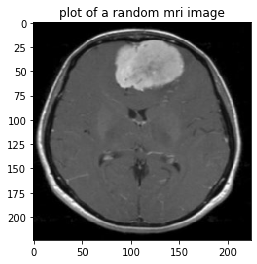

In [11]:
from random import randrange
plt.imshow(X[randrange(253)], interpolation='nearest')
plt.title('plot of a random mri image')
plt.show()

In [12]:
X = X.astype('float32')
X /= 255.
y_yes = np.full(len(yes),1)
y_no = np.full(len(no),0)
y=np.concatenate([y_yes,y_no])
y.shape

(253,)

In [13]:
# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [14]:
print("X_train :",X_train.shape,
      "y_train :",y_train.shape,
     "\nX_test :",X_test.shape,
     "y_test :",y_test.shape)

X_train : (202, 224, 224, 3) y_train : (202,) 
X_test : (51, 224, 224, 3) y_test : (51,)


In [15]:
from tensorflow.keras import applications
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization

base_model = applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))
base_model.trainable = False


model = Sequential(name='transferred_model')
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

87916544/87910968 [==============================] - 2s 0us/step
Model: "transferred_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
__________________________________________________

In [17]:
import time
start = time.time()
# fit the parameters
history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=10,
    verbose = 1,
    validation_data = (X_test, y_test))
print('It took', time.time()-start, 'seconds to train for 10 epochs.')

Epoch 1/10
13/13 [==============================] - 5s 352ms/step - loss: 1.3862 - accuracy: 0.5545 - val_loss: 0.5460 - val_accuracy: 0.6667
Epoch 2/10
13/13 [==============================] - 1s 113ms/step - loss: 0.7715 - accuracy: 0.7030 - val_loss: 0.3483 - val_accuracy: 0.8627
Epoch 3/10
13/13 [==============================] - 1s 113ms/step - loss: 0.7121 - accuracy: 0.6584 - val_loss: 0.3391 - val_accuracy: 0.8627
Epoch 4/10
13/13 [==============================] - 1s 113ms/step - loss: 0.5442 - accuracy: 0.7673 - val_loss: 0.3937 - val_accuracy: 0.8235
Epoch 5/10
13/13 [==============================] - 1s 112ms/step - loss: 0.3885 - accuracy: 0.8515 - val_loss: 0.3041 - val_accuracy: 0.9020
Epoch 6/10
13/13 [==============================] - 1s 112ms/step - loss: 0.4667 - accuracy: 0.8416 - val_loss: 0.4322 - val_accuracy: 0.8039
Epoch 7/10
13/13 [==============================] - 1s 113ms/step - loss: 0.3713 - accuracy: 0.8317 - val_loss: 0.2863 - val_accuracy: 0.8824
Epoch 

Training accuracy after 10 epochs: 0.8861
Training loss after 10 epochs: 0.3083


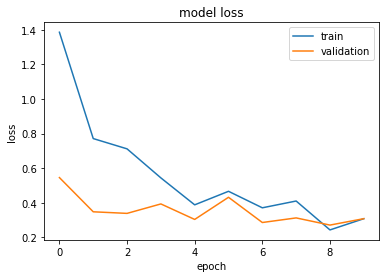

In [18]:
print('Training accuracy after 10 epochs: %.4f'%history.history['accuracy'][-1])
print('Training loss after 10 epochs: %.4f'%history.history['loss'][-1])
# plot the loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

**Looks good for 30s of training! There's also not much bias, which means our model is doing a good job of not overfitting. Let's try to decrease the batch_size and run for more epochs and see what happens.**

In [20]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.98):
            print("\nReached 98% validation accuracy! stopping training now.")
            self.model.stop_training = True
callbacks = myCallback()

In [21]:
start = time.time()
# fit the parameters
history = model.fit(
    X_train,
    y_train,
    batch_size=4,
    epochs=40,
    verbose = 0,
    validation_data = (X_test, y_test),
    callbacks=[callbacks])
print('It took', time.time()-start, 'seconds to train for 40 more epochs.')

It took 103.97497725486755 seconds to train for 40 more epochs.


In [23]:
print('Training accuracy after 50 total epochs: %.4f'%history.history['accuracy'][-1])
print('Testing accuracy after 50 total epochs: %.4f'%history.history['val_accuracy'][-1])

Training accuracy after 50 total epochs: 0.9703
Testing accuracy after 50 total epochs: 0.9412


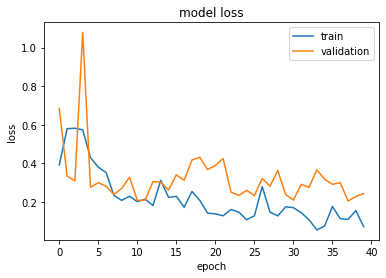

In [24]:
# plot the loss curves
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

**This is interesting! In a little over 2 minuts, the model acheived 97% training accuracy and 94% validation accuracy. This is despite only having few samples. We should expect that using data augmentation techniques, we could improve the accuracy even more.**